<a href="https://colab.research.google.com/github/aminaakm/amina/blob/main/with_covariates_and_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving withcovariatespy.csv to withcovariatespy.csv


/tmp/ipython-input-3765897457.py:12: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


✅ File loaded successfully.
--- Preparing data for modeling...
✅ Data preprocessing complete.

Predictor variables being used:
['bmi', 'age', 'residence_2 Urban', 'sex_2 Female', 'stateid_10 Bihar', 'stateid_11 Sikkim', 'stateid_12 Arunachal Pradesh', 'stateid_13 Nagaland', 'stateid_14 Manipur', 'stateid_15 Mizoram', 'stateid_16 Tripura', 'stateid_17 Meghalaya', 'stateid_18 Assam', 'stateid_19 West Bengal', 'stateid_2 Himachal Pradesh', 'stateid_20 Jharkhand', 'stateid_21 Odisha', 'stateid_22 Chhatisgarh', 'stateid_23 Madhya Pradesh', 'stateid_24 Gujarat', 'stateid_25 Daman and Diu', 'stateid_26 Dadra and Nagar Haveli', 'stateid_27 Maharashtra', 'stateid_28 Andhra Pradesh', 'stateid_29 Karnataka', 'stateid_3 Punjab', 'stateid_30 Goa', 'stateid_31 Lakshadweep', 'stateid_32 Kerala', 'stateid_33 Tamil Nadu', 'stateid_34 Puducherry', 'stateid_35 Andaman and Nicobar', 'stateid_36 Telangana', 'stateid_4 Chandigarh', 'stateid_5 Uttarakhand', 'stateid_6 Haryana', 'stateid_7 Delhi', 'stateid_8 

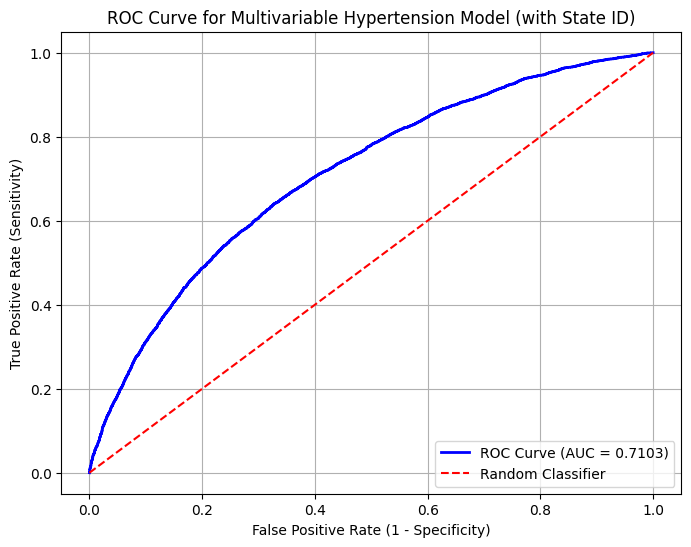

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

# --- 1. Load Data ---
# IMPORTANT: Replace 'your_data_file.csv' with the actual name of your file.
file_name = 'withcovariatespy.csv'
try:
    df = pd.read_csv(file_name)
    print("✅ File loaded successfully.")
except FileNotFoundError:
    print(f"❌ ERROR: File '{file_name}' not found. Please check the name and re-upload if needed.")


# --- 2. Prepare Data ---
print("--- Preparing data for modeling...")
# Select only the columns needed for the model
model_df = df[['residence', 'bmi', 'age', 'sex', 'htn_status', 'stateid']].copy()

# Clean the target variable: 1 for 'Yes', 0 for 'No'
model_df['htn_binary'] = model_df['htn_status'].apply(lambda x: 1 if '1' in str(x) else 0)

# Convert categorical predictors to numeric dummy variables, including 'stateid'
model_df = pd.get_dummies(model_df, columns=['residence', 'sex', 'stateid'], drop_first=True)

# Convert 'bmi' and 'age' to numeric, coercing errors to NaN
model_df['bmi'] = pd.to_numeric(model_df['bmi'], errors='coerce')
model_df['age'] = pd.to_numeric(model_df['age'], errors='coerce')

# Handle any potential missing values created by coercion
model_df.dropna(inplace=True)
print("✅ Data preprocessing complete.")


# --- 3. Define Predictors (X) and Outcome (y) ---
# Use the exact column names created by pd.get_dummies
# Based on our conversation and including 'stateid' dummy variables
# We need to dynamically get the list of predictor columns
predictor_cols = [col for col in model_df.columns if col not in ['htn_status', 'htn_binary']]
X = model_df[predictor_cols]
y = model_df['htn_binary']

print("\nPredictor variables being used:")
print(X.columns.tolist())


# --- 4. Scale and Split the Data ---
# Scale numeric features for better model performance
scaler = StandardScaler()
X_scaled = X.copy()
# Only scale the numeric columns ('bmi' and 'age')
numeric_cols = ['bmi', 'age']
X_scaled[numeric_cols] = scaler.fit_transform(X_scaled[numeric_cols])

# Split data into training and testing sets for valid evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print("✅ Data split into training and testing sets.")


# --- 5. Train Model and Evaluate with ROC/AUC ---
print("--- Training and evaluating the model...")
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set and calculate AUC
y_probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

print(f"\nModel Performance on Test Data:")
print(f"Area Under the ROC Curve (AUC) = {auc:.4f}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for Multivariable Hypertension Model (with State ID)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()